**Sources:**

The code is a further development of this preliminary project:

[1] https://github.com/bjorneme/preliminary/tree/main

The state-of-the-art model used as inspiration for multi-label classification on ChestX-ray14 is:

[2] https://github.com/syednabilashraf/SynthEnsemble/tree/main

The code used for develop BYOL architecture is:

[3] https://docs.lightly.ai/self-supervised-learning/examples/byol.html

**Import Libraries**

In [1]:
pip install lightly mambavision transformers mamba_ssm timm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Standard Libraries
import os
import copy
import random
from glob import glob
from PIL import Image
import zipfile

# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt

# Progress Bar
from tqdm import tqdm

# Machine Learning Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, f1_score
from torch.amp import GradScaler, autocast

# BYOL library
from lightly.transforms.byol_transform import BYOLTransform, BYOLView1Transform, BYOLView2Transform
from lightly.models.modules import BYOLProjectionHead, BYOLPredictionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.loss import NegativeCosineSimilarity
from lightly.utils.scheduler import cosine_schedule

# Hugging Face transformers to load the MambaVision model
from transformers import AutoModel

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Define Parameters**

In [3]:
# Paths
ZIP_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14.zip'
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/Data/chestX-ray14-extracted'

# Model
MODEL_NAME = "nvidia/MambaVision-T2-1K"

# Disease labels
disease_labels = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema',
    'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
    'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]

# Parameters BYOL pre-training
LEARNING_RATE_BYOL = 0.06
EPOCHS_BYOL = 100
BATCH_SIZE_BYOL = 128

# Parameters training
LEARNING_RATE = 0.001
LEARNING_RATE_FINE_TUNING = 0.0001
EPOCHS = 3
EPOCHS_FINE_TUNING = 100
BATCH_SIZE = 32

# Parameters early stopping
EARLY_STOPPING_PATIENCE = 10

# Parameters learning rate scheduler
LEARNING_RATE_SCHEDULER_PATIENCE = 1
LEARNING_RATE_SCHEDULER_MODE = 'min'
LEARNING_RATE_SCHEDULER_FACTOR = 0.5

# Other parameters
SEED = 42
NUM_WORKERS = 64

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


**Set Seed for Reproducibility**

In [4]:
def seed_everything(seed=SEED):
    """
    Sets the seed to ensure reproducibility.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Apply the seed
seed_everything()

# **Step 1: Load Data**

In [5]:
def extract_data(zip_path, extracted_path):
    """
    Extracts the ZIP file of the dataset.
    """
    os.makedirs(extracted_path, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)

# Extract ChestX-ray14 dataset
# extract_data(ZIP_PATH, EXTRACTED_PATH)

# **Step 2: Data Preprocessing**

In [6]:
def load_labels(csv_path, extracted_path):
    """
    Read labels from CSV, maps images to paths, and create binary disease labels.
    """

    # Read the CSV containing labels
    labels_df = pd.read_csv(csv_path)

    # Create binary columns for each disease label
    for disease in disease_labels:
        labels_df[disease] = labels_df['Finding Labels'].str.contains(disease).astype(int)

    # Create binary column for 'No Finding'
    labels_df['No Finding'] = labels_df['Finding Labels'].str.contains('No Finding').astype(int)

    # Map images to their full path
    labels_df['Path'] = labels_df['Image Index'].map(
        {os.path.basename(path): path for path in glob(os.path.join(extracted_path, '**', 'images', '*.png'))}
    )
    
    return labels_df

# Path to the labels CSV file
labels_csv_path = os.path.join(EXTRACTED_PATH, 'Data_Entry_2017.csv')

# Load and preprocess the labels
df = load_labels(labels_csv_path, EXTRACTED_PATH)

**Split Dataset**

In [7]:
# Split based on patients
unique_patients = df['Patient ID'].unique()

# Split patients into training, validation and test sets
train_val_patients, test_patients = train_test_split(
    unique_patients, test_size=0.2, random_state=SEED
)
train_patients, val_patients = train_test_split(
    train_val_patients, test_size=0.125, random_state=SEED
)

# Create dataframes for training, validation, and test sets
train_df = df[df['Patient ID'].isin(train_patients)].reset_index(drop=True)
val_df = df[df['Patient ID'].isin(val_patients)].reset_index(drop=True)
test_df = df[df['Patient ID'].isin(test_patients)].reset_index(drop=True)

# Verify Split Sizes
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 78614
Validation size: 11212
Test size: 22294


**Define Dataset for Chest X-ray images**

In [8]:
class ChestXrayDataset(Dataset):
    """
    Create dataset for Chest X-ray images.
    """
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        # Get image and labels
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)
        label = self.df.iloc[idx][disease_labels].values.astype(np.float32)
        
        # Apply transformation on image
        image = self.transform(image)
        
        return image, label

**Define Data Transformations**

In [9]:
# Define transformations for training data
train_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Apply random horizontal flip
    transforms.RandomHorizontalFlip(),

    # Randomly rotate the image with ±10 degrees
    transforms.RandomRotation(10),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Define transformations for test data
test_transforms = transforms.Compose([

    # Convert image to PIL format
    transforms.ToPILImage(),

    # Convert to 3 channels
    transforms.Grayscale(num_output_channels=3),

    # Resize the image to 224x224
    transforms.Resize(224),

    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize using ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**Create Datasets**

In [10]:
train_dataset = ChestXrayDataset(train_df, transform=train_transforms)
val_dataset = ChestXrayDataset(val_df, transform=test_transforms)
test_dataset = ChestXrayDataset(test_df, transform=test_transforms)

**Create DataLoaders**

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# **Step 3: BYOL Pre-training**

**Define the BYOL transformations**

In [12]:
def get_xray_transform():
    return transforms.Compose([
        
        # Convert image to PIL format
        transforms.ToPILImage(),

        # Convert to 3 channels
        transforms.Grayscale(num_output_channels=3),

        # Randomly resize the image
        transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),

        # Apply random horizontal flip
        transforms.RandomHorizontalFlip(),

        # Randomly rotate the image with ±10 degrees
        transforms.RandomRotation(10),

        # Apply random brightness and contrast
        transforms.ColorJitter(
            brightness=(0.8, 1.2),
            contrast=(0.8, 1.2)
        ),

        # Convert the image to a PyTorch tensor
        transforms.ToTensor(),

        # Normalize using ImageNet mean and std
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])

byol_transform = BYOLTransform(
    view_1_transform=get_xray_transform(),
    view_2_transform=get_xray_transform()
)

**Define the BYOL model**

In [13]:
class BYOL(nn.Module):
    def __init__(self, model_name="nvidia/MambaVision-T2-1K"):
        super().__init__()

        # The online network
        self.backbone = AutoModel.from_pretrained(model_name, trust_remote_code=True)
        self.projection_head = BYOLProjectionHead(self.backbone.model.head.in_features, 1024, 256)
        self.prediction_head = BYOLPredictionHead(256, 1024, 256)

        # The target network
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        # Freeze the teacher network. Only update using EMA
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward_student(self, x):
        # Forward pass student network
        y, _ = self.backbone(x)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_teacher(self, x):
        # Forward pass teacher network
        y, _ = self.backbone_momentum(x)
        z = self.projection_head_momentum(y)
        return z.detach()

# Initalize BYOL model
byol_model = BYOL(MODEL_NAME).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
2025-04-13 00:13:36.814496: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 00:13:36.828677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:

**Create BYOL Dataset**

In [14]:
class BYOLDataset(torch.utils.data.Dataset):
    """
    Dataset for BYOL.
    Returns two augmented versions of each image.
    """
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image path
        img_path = self.df.iloc[idx]['Path']
        image = plt.imread(img_path)

        # Apply the BYOL transform on image
        view1, view2 = self.transform(image)

        # Return two different views
        return view1, view2

# Create dataset for training and validation using BYOL
byol_train_dataset = BYOLDataset(train_df, transform=byol_transform)
byol_val_dataset = BYOLDataset(val_df, transform=byol_transform)

**Initialize BYOL DataLoader**

In [15]:
# Initialize loader for BYOL training
byol_train_loader = DataLoader(
    byol_train_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=True,
    num_workers=NUM_WORKERS,
    drop_last=True
)

# Initialize loader for BYOL validation
byol_val_loader = DataLoader(
    byol_val_dataset,
    batch_size=BATCH_SIZE_BYOL,
    shuffle=False,
    num_workers=NUM_WORKERS,
    drop_last=False
)

**Initialize Optimizer and Loss for BYOL**

In [16]:
criterion = NegativeCosineSimilarity()
optimizer_byol = torch.optim.SGD(byol_model.parameters(), lr=LEARNING_RATE_BYOL)

**Train BYOL Model**

In [17]:
def train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer, patience, epochs=10):
    """
    Pre-train the backbone and evaluate it on the validation set after each epoch.
    """

    # List to store byol loss
    byol_train_losses = []
    byol_val_losses = []

    # Early stopping parameters
    best_loss = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):


        # ---Training---
        byol_model.train()
        train_loss = 0.0

        # For mixed precision
        scaler = GradScaler()

        # Progress bar
        progress_bar = tqdm(byol_train_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        # Scheduler
        momentum_val = cosine_schedule(epoch, epochs, 0.996, 1)

        for batch in progress_bar:
            x0, x1 = batch
            update_momentum(byol_model.backbone, byol_model.backbone_momentum, m=momentum_val)
            update_momentum(byol_model.projection_head, byol_model.projection_head_momentum, m=momentum_val)

            x0 = x0.to(device)
            x1 = x1.to(device)

            # Clear gradients
            optimizer.zero_grad()

            with autocast('cuda'):

                # Forward pass
                p0 = byol_model.forward_student(x0)
                z0 = byol_model.forward_teacher(x0)
                p1 = byol_model.forward_student(x1)
                z1 = byol_model.forward_teacher(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

            # Backward pass + scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss = train_loss / len(byol_train_loader)
        byol_train_losses.append(train_loss)


        # ---Validation---
        byol_model.eval()
        val_loss = 0

        # Progress bar
        progress_bar = tqdm(byol_val_loader, desc=f"BYOL Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for batch in progress_bar:
                x0, x1 = batch

                x0 = x0.to(device)
                x1 = x1.to(device)

                # Forward pass
                p0 = byol_model.forward_student(x0)
                z0 = byol_model.forward_teacher(x0)
                p1 = byol_model.forward_student(x1)
                z1 = byol_model.forward_teacher(x1)

                # Compute loss
                loss = 0.5 * (criterion(p0, z1) + criterion(p1, z0))

                val_loss  += loss.item()
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss = val_loss / len(byol_val_loader)
        byol_val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f}")

        # Early stopping
        if best_loss > val_loss:

            # Reset early stopping parameters
            best_loss = val_loss
            epochs_without_improvement = 0

            # Save the best model
            torch.save(byol_model.state_dict(), 'byol_fourth_augmentation.pt')
            print(f"New best model with Validation Loss: {val_loss:.4f}")
        else:
            epochs_without_improvement += 1

            # Condition for doing early stopping
            if epochs_without_improvement >= patience :
                print(f"Early stopping.")
                break

    # Load the best model
    byol_model.load_state_dict(torch.load('byol_fourth_augmentation.pt', weights_only=True))

    return byol_train_losses, byol_val_losses

# Train the model
byol_train_losses, byol_val_losses = train_model(byol_model, byol_train_loader, byol_val_loader, criterion, optimizer_byol, EARLY_STOPPING_PATIENCE, EPOCHS_BYOL)

BYOL Epoch 1/100: 100%|██████████| 88/88 [00:43<00:00,  2.02it/s, Loss=-0.762]


Epoch 1/100 | Training Loss: -0.7155 | Validation Loss: -0.8641
New best model with Validation Loss: -0.8641


BYOL Epoch 2/100: 100%|██████████| 88/88 [00:32<00:00,  2.70it/s, Loss=-0.91] 


Epoch 2/100 | Training Loss: -0.8845 | Validation Loss: -0.9300
New best model with Validation Loss: -0.9300


BYOL Epoch 3/100: 100%|██████████| 88/88 [00:33<00:00,  2.66it/s, Loss=-0.942]


Epoch 3/100 | Training Loss: -0.9244 | Validation Loss: -0.9359
New best model with Validation Loss: -0.9359


BYOL Epoch 4/100: 100%|██████████| 88/88 [00:34<00:00,  2.54it/s, Loss=-0.96] 


Epoch 4/100 | Training Loss: -0.9400 | Validation Loss: -0.9580
New best model with Validation Loss: -0.9580


BYOL Epoch 5/100: 100%|██████████| 88/88 [00:34<00:00,  2.57it/s, Loss=-0.97] 


Epoch 5/100 | Training Loss: -0.9475 | Validation Loss: -0.9557


BYOL Epoch 6/100: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s, Loss=-0.971]


Epoch 6/100 | Training Loss: -0.9525 | Validation Loss: -0.9647
New best model with Validation Loss: -0.9647


BYOL Epoch 7/100: 100%|██████████| 88/88 [00:34<00:00,  2.56it/s, Loss=-0.977]


Epoch 7/100 | Training Loss: -0.9557 | Validation Loss: -0.9698
New best model with Validation Loss: -0.9698


BYOL Epoch 8/100: 100%|██████████| 88/88 [00:34<00:00,  2.54it/s, Loss=-0.979]


Epoch 8/100 | Training Loss: -0.9582 | Validation Loss: -0.9695


BYOL Epoch 9/100: 100%|██████████| 88/88 [00:35<00:00,  2.51it/s, Loss=-0.979]


Epoch 9/100 | Training Loss: -0.9603 | Validation Loss: -0.9724
New best model with Validation Loss: -0.9724


BYOL Epoch 10/100: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s, Loss=-0.981]


Epoch 10/100 | Training Loss: -0.9620 | Validation Loss: -0.9751
New best model with Validation Loss: -0.9751


BYOL Epoch 11/100: 100%|██████████| 88/88 [00:34<00:00,  2.53it/s, Loss=-0.984]


Epoch 11/100 | Training Loss: -0.9637 | Validation Loss: -0.9744


BYOL Epoch 12/100: 100%|██████████| 88/88 [00:35<00:00,  2.50it/s, Loss=-0.984]


Epoch 12/100 | Training Loss: -0.9653 | Validation Loss: -0.9772
New best model with Validation Loss: -0.9772


BYOL Epoch 13/100: 100%|██████████| 88/88 [00:33<00:00,  2.59it/s, Loss=-0.984]


Epoch 13/100 | Training Loss: -0.9667 | Validation Loss: -0.9781
New best model with Validation Loss: -0.9781


BYOL Epoch 14/100: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s, Loss=-0.986]


Epoch 14/100 | Training Loss: -0.9680 | Validation Loss: -0.9788
New best model with Validation Loss: -0.9788


BYOL Epoch 15/100: 100%|██████████| 88/88 [00:35<00:00,  2.49it/s, Loss=-0.982]


Epoch 15/100 | Training Loss: -0.9691 | Validation Loss: -0.9791
New best model with Validation Loss: -0.9791


BYOL Epoch 16/100: 100%|██████████| 88/88 [00:35<00:00,  2.50it/s, Loss=-0.983]


Epoch 16/100 | Training Loss: -0.9702 | Validation Loss: -0.9800
New best model with Validation Loss: -0.9800


BYOL Epoch 17/100: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s, Loss=-0.988]


Epoch 17/100 | Training Loss: -0.9710 | Validation Loss: -0.9805
New best model with Validation Loss: -0.9805


BYOL Epoch 18/100: 100%|██████████| 88/88 [00:34<00:00,  2.53it/s, Loss=-0.986]


Epoch 18/100 | Training Loss: -0.9717 | Validation Loss: -0.9800


BYOL Epoch 19/100: 100%|██████████| 88/88 [00:34<00:00,  2.52it/s, Loss=-0.986]


Epoch 19/100 | Training Loss: -0.9723 | Validation Loss: -0.9809
New best model with Validation Loss: -0.9809


BYOL Epoch 20/100: 100%|██████████| 88/88 [00:35<00:00,  2.51it/s, Loss=-0.987]


Epoch 20/100 | Training Loss: -0.9730 | Validation Loss: -0.9808


BYOL Epoch 21/100: 100%|██████████| 88/88 [00:33<00:00,  2.61it/s, Loss=-0.986]


Epoch 21/100 | Training Loss: -0.9734 | Validation Loss: -0.9819
New best model with Validation Loss: -0.9819


BYOL Epoch 22/100: 100%|██████████| 88/88 [00:33<00:00,  2.60it/s, Loss=-0.987]


Epoch 22/100 | Training Loss: -0.9738 | Validation Loss: -0.9823
New best model with Validation Loss: -0.9823


BYOL Epoch 23/100: 100%|██████████| 88/88 [00:34<00:00,  2.58it/s, Loss=-0.989]


Epoch 23/100 | Training Loss: -0.9742 | Validation Loss: -0.9826
New best model with Validation Loss: -0.9826


BYOL Epoch 24/100: 100%|██████████| 88/88 [00:34<00:00,  2.52it/s, Loss=-0.987]


Epoch 24/100 | Training Loss: -0.9746 | Validation Loss: -0.9827
New best model with Validation Loss: -0.9827


BYOL Epoch 25/100: 100%|██████████| 88/88 [00:34<00:00,  2.54it/s, Loss=-0.985]


Epoch 25/100 | Training Loss: -0.9749 | Validation Loss: -0.9828
New best model with Validation Loss: -0.9828


BYOL Epoch 26/100: 100%|██████████| 88/88 [00:35<00:00,  2.48it/s, Loss=-0.987]


Epoch 26/100 | Training Loss: -0.9752 | Validation Loss: -0.9831
New best model with Validation Loss: -0.9831


BYOL Epoch 27/100: 100%|██████████| 88/88 [00:34<00:00,  2.52it/s, Loss=-0.987]


Epoch 27/100 | Training Loss: -0.9754 | Validation Loss: -0.9820


BYOL Epoch 28/100: 100%|██████████| 88/88 [00:36<00:00,  2.40it/s, Loss=-0.987]


Epoch 28/100 | Training Loss: -0.9755 | Validation Loss: -0.9834
New best model with Validation Loss: -0.9834


BYOL Epoch 29/100: 100%|██████████| 88/88 [00:34<00:00,  2.58it/s, Loss=-0.988]


Epoch 29/100 | Training Loss: -0.9758 | Validation Loss: -0.9834


BYOL Epoch 30/100: 100%|██████████| 88/88 [00:34<00:00,  2.54it/s, Loss=-0.988]


Epoch 30/100 | Training Loss: -0.9758 | Validation Loss: -0.9835
New best model with Validation Loss: -0.9835


BYOL Epoch 31/100: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s, Loss=-0.986]


Epoch 31/100 | Training Loss: -0.9760 | Validation Loss: -0.9838
New best model with Validation Loss: -0.9838


BYOL Epoch 32/100: 100%|██████████| 88/88 [00:33<00:00,  2.60it/s, Loss=-0.987]


Epoch 32/100 | Training Loss: -0.9762 | Validation Loss: -0.9833


BYOL Epoch 33/100: 100%|██████████| 88/88 [00:33<00:00,  2.61it/s, Loss=-0.988]


Epoch 33/100 | Training Loss: -0.9764 | Validation Loss: -0.9841
New best model with Validation Loss: -0.9841


BYOL Epoch 34/100: 100%|██████████| 88/88 [00:34<00:00,  2.57it/s, Loss=-0.988]


Epoch 34/100 | Training Loss: -0.9765 | Validation Loss: -0.9841


BYOL Epoch 35/100: 100%|██████████| 88/88 [00:33<00:00,  2.63it/s, Loss=-0.988]


Epoch 35/100 | Training Loss: -0.9766 | Validation Loss: -0.9840


BYOL Epoch 36/100: 100%|██████████| 88/88 [00:33<00:00,  2.60it/s, Loss=-0.989]


Epoch 36/100 | Training Loss: -0.9767 | Validation Loss: -0.9843
New best model with Validation Loss: -0.9843


BYOL Epoch 37/100: 100%|██████████| 88/88 [00:34<00:00,  2.52it/s, Loss=-0.988]


Epoch 37/100 | Training Loss: -0.9769 | Validation Loss: -0.9843


BYOL Epoch 38/100: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s, Loss=-0.988]


Epoch 38/100 | Training Loss: -0.9770 | Validation Loss: -0.9843


BYOL Epoch 39/100: 100%|██████████| 88/88 [00:34<00:00,  2.53it/s, Loss=-0.988]


Epoch 39/100 | Training Loss: -0.9771 | Validation Loss: -0.9846
New best model with Validation Loss: -0.9846


BYOL Epoch 40/100: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s, Loss=-0.989]


Epoch 40/100 | Training Loss: -0.9772 | Validation Loss: -0.9842


BYOL Epoch 41/100: 100%|██████████| 88/88 [00:34<00:00,  2.57it/s, Loss=-0.989]


Epoch 41/100 | Training Loss: -0.9773 | Validation Loss: -0.9848
New best model with Validation Loss: -0.9848


BYOL Epoch 42/100: 100%|██████████| 88/88 [00:34<00:00,  2.54it/s, Loss=-0.989]


Epoch 42/100 | Training Loss: -0.9775 | Validation Loss: -0.9849
New best model with Validation Loss: -0.9849


BYOL Epoch 43/100: 100%|██████████| 88/88 [00:35<00:00,  2.48it/s, Loss=-0.988]


Epoch 43/100 | Training Loss: -0.9777 | Validation Loss: -0.9848


BYOL Epoch 44/100: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s, Loss=-0.988]


Epoch 44/100 | Training Loss: -0.9779 | Validation Loss: -0.9847


BYOL Epoch 45/100: 100%|██████████| 88/88 [00:37<00:00,  2.38it/s, Loss=-0.989]


Epoch 45/100 | Training Loss: -0.9780 | Validation Loss: -0.9852
New best model with Validation Loss: -0.9852


BYOL Epoch 46/100: 100%|██████████| 88/88 [00:35<00:00,  2.47it/s, Loss=-0.99] 


Epoch 46/100 | Training Loss: -0.9781 | Validation Loss: -0.9851


BYOL Epoch 47/100: 100%|██████████| 88/88 [00:34<00:00,  2.52it/s, Loss=-0.988]


Epoch 47/100 | Training Loss: -0.9784 | Validation Loss: -0.9856
New best model with Validation Loss: -0.9856


BYOL Epoch 48/100: 100%|██████████| 88/88 [00:35<00:00,  2.51it/s, Loss=-0.988]


Epoch 48/100 | Training Loss: -0.9785 | Validation Loss: -0.9852


BYOL Epoch 49/100: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s, Loss=-0.988]


Epoch 49/100 | Training Loss: -0.9786 | Validation Loss: -0.9857
New best model with Validation Loss: -0.9857


BYOL Epoch 50/100: 100%|██████████| 88/88 [00:33<00:00,  2.61it/s, Loss=-0.989]


Epoch 50/100 | Training Loss: -0.9787 | Validation Loss: -0.9847


BYOL Epoch 51/100: 100%|██████████| 88/88 [00:34<00:00,  2.56it/s, Loss=-0.989]


Epoch 51/100 | Training Loss: -0.9789 | Validation Loss: -0.9854


BYOL Epoch 52/100: 100%|██████████| 88/88 [00:33<00:00,  2.61it/s, Loss=-0.989]


Epoch 52/100 | Training Loss: -0.9790 | Validation Loss: -0.9856


BYOL Epoch 53/100: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s, Loss=-0.99] 


Epoch 53/100 | Training Loss: -0.9791 | Validation Loss: -0.9855


BYOL Epoch 54/100: 100%|██████████| 88/88 [00:34<00:00,  2.58it/s, Loss=-0.989]


Epoch 54/100 | Training Loss: -0.9792 | Validation Loss: -0.9854


BYOL Epoch 55/100: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s, Loss=-0.99] 


Epoch 55/100 | Training Loss: -0.9794 | Validation Loss: -0.9855


BYOL Epoch 56/100: 100%|██████████| 88/88 [00:33<00:00,  2.61it/s, Loss=-0.99] 


Epoch 56/100 | Training Loss: -0.9795 | Validation Loss: -0.9863
New best model with Validation Loss: -0.9863


BYOL Epoch 57/100: 100%|██████████| 88/88 [00:34<00:00,  2.56it/s, Loss=-0.99] 


Epoch 57/100 | Training Loss: -0.9797 | Validation Loss: -0.9863
New best model with Validation Loss: -0.9863


BYOL Epoch 58/100: 100%|██████████| 88/88 [00:34<00:00,  2.52it/s, Loss=-0.99] 


Epoch 58/100 | Training Loss: -0.9797 | Validation Loss: -0.9862


BYOL Epoch 59/100: 100%|██████████| 88/88 [00:34<00:00,  2.52it/s, Loss=-0.989]


Epoch 59/100 | Training Loss: -0.9799 | Validation Loss: -0.9861


BYOL Epoch 60/100: 100%|██████████| 88/88 [00:34<00:00,  2.55it/s, Loss=-0.99] 


Epoch 60/100 | Training Loss: -0.9800 | Validation Loss: -0.9865
New best model with Validation Loss: -0.9865


BYOL Epoch 61/100: 100%|██████████| 88/88 [00:33<00:00,  2.60it/s, Loss=-0.99] 


Epoch 61/100 | Training Loss: -0.9800 | Validation Loss: -0.9866
New best model with Validation Loss: -0.9866


BYOL Epoch 62/100: 100%|██████████| 88/88 [00:34<00:00,  2.56it/s, Loss=-0.99] 


Epoch 62/100 | Training Loss: -0.9802 | Validation Loss: -0.9858


BYOL Epoch 63/100: 100%|██████████| 88/88 [00:34<00:00,  2.53it/s, Loss=-0.99] 


Epoch 63/100 | Training Loss: -0.9801 | Validation Loss: -0.9865


BYOL Epoch 64/100: 100%|██████████| 88/88 [00:33<00:00,  2.62it/s, Loss=-0.988]


Epoch 64/100 | Training Loss: -0.9803 | Validation Loss: -0.9844


BYOL Epoch 65/100: 100%|██████████| 88/88 [00:33<00:00,  2.59it/s, Loss=-0.99] 


Epoch 65/100 | Training Loss: -0.9804 | Validation Loss: -0.9868
New best model with Validation Loss: -0.9868


BYOL Epoch 66/100: 100%|██████████| 88/88 [00:34<00:00,  2.56it/s, Loss=-0.991]


Epoch 66/100 | Training Loss: -0.9805 | Validation Loss: -0.9871
New best model with Validation Loss: -0.9871


BYOL Epoch 67/100: 100%|██████████| 88/88 [00:35<00:00,  2.50it/s, Loss=-0.99] 


Epoch 67/100 | Training Loss: -0.9805 | Validation Loss: -0.9870


BYOL Epoch 68/100: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s, Loss=-0.99] 


Epoch 68/100 | Training Loss: -0.9806 | Validation Loss: -0.9870


BYOL Epoch 69/100: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s, Loss=-0.99] 


Epoch 69/100 | Training Loss: -0.9806 | Validation Loss: -0.9861


BYOL Epoch 70/100: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s, Loss=-0.99] 


Epoch 70/100 | Training Loss: -0.9807 | Validation Loss: -0.9863


BYOL Epoch 71/100: 100%|██████████| 88/88 [00:37<00:00,  2.38it/s, Loss=-0.99] 


Epoch 71/100 | Training Loss: -0.9808 | Validation Loss: -0.9863


BYOL Epoch 72/100: 100%|██████████| 88/88 [00:37<00:00,  2.37it/s, Loss=-0.991]


Epoch 72/100 | Training Loss: -0.9808 | Validation Loss: -0.9867


BYOL Epoch 73/100: 100%|██████████| 88/88 [00:36<00:00,  2.38it/s, Loss=-0.99] 


Epoch 73/100 | Training Loss: -0.9809 | Validation Loss: -0.9872
New best model with Validation Loss: -0.9872


BYOL Epoch 74/100: 100%|██████████| 88/88 [00:38<00:00,  2.29it/s, Loss=-0.991]


Epoch 74/100 | Training Loss: -0.9809 | Validation Loss: -0.9872
New best model with Validation Loss: -0.9872


BYOL Epoch 75/100: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s, Loss=-0.99] 


Epoch 75/100 | Training Loss: -0.9810 | Validation Loss: -0.9867


BYOL Epoch 76/100: 100%|██████████| 88/88 [00:38<00:00,  2.31it/s, Loss=-0.991]


Epoch 76/100 | Training Loss: -0.9811 | Validation Loss: -0.9872


BYOL Epoch 77/100: 100%|██████████| 88/88 [00:39<00:00,  2.24it/s, Loss=-0.99] 


Epoch 77/100 | Training Loss: -0.9811 | Validation Loss: -0.9874
New best model with Validation Loss: -0.9874


BYOL Epoch 78/100: 100%|██████████| 88/88 [00:34<00:00,  2.53it/s, Loss=-0.991]


Epoch 78/100 | Training Loss: -0.9812 | Validation Loss: -0.9873


BYOL Epoch 79/100: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s, Loss=-0.991]


Epoch 79/100 | Training Loss: -0.9813 | Validation Loss: -0.9873


BYOL Epoch 80/100: 100%|██████████| 88/88 [00:32<00:00,  2.71it/s, Loss=-0.991]


Epoch 80/100 | Training Loss: -0.9814 | Validation Loss: -0.9874


BYOL Epoch 81/100: 100%|██████████| 88/88 [00:37<00:00,  2.36it/s, Loss=-0.99] 


Epoch 81/100 | Training Loss: -0.9814 | Validation Loss: -0.9873


BYOL Epoch 82/100: 100%|██████████| 88/88 [00:31<00:00,  2.82it/s, Loss=-0.991]


Epoch 82/100 | Training Loss: -0.9815 | Validation Loss: -0.9878
New best model with Validation Loss: -0.9878


BYOL Epoch 83/100: 100%|██████████| 88/88 [00:37<00:00,  2.34it/s, Loss=-0.991]


Epoch 83/100 | Training Loss: -0.9815 | Validation Loss: -0.9874


BYOL Epoch 84/100: 100%|██████████| 88/88 [00:32<00:00,  2.68it/s, Loss=-0.991]


Epoch 84/100 | Training Loss: -0.9816 | Validation Loss: -0.9876


BYOL Epoch 85/100: 100%|██████████| 88/88 [00:24<00:00,  3.55it/s, Loss=-0.991]


Epoch 85/100 | Training Loss: -0.9817 | Validation Loss: -0.9874


BYOL Epoch 86/100: 100%|██████████| 88/88 [00:24<00:00,  3.63it/s, Loss=-0.991]


Epoch 86/100 | Training Loss: -0.9817 | Validation Loss: -0.9878
New best model with Validation Loss: -0.9878


BYOL Epoch 87/100: 100%|██████████| 88/88 [00:24<00:00,  3.66it/s, Loss=-0.991]


Epoch 87/100 | Training Loss: -0.9818 | Validation Loss: -0.9876


BYOL Epoch 88/100: 100%|██████████| 88/88 [00:24<00:00,  3.66it/s, Loss=-0.991]


Epoch 88/100 | Training Loss: -0.9819 | Validation Loss: -0.9877


BYOL Epoch 89/100: 100%|██████████| 88/88 [00:24<00:00,  3.63it/s, Loss=-0.991]


Epoch 89/100 | Training Loss: -0.9819 | Validation Loss: -0.9882
New best model with Validation Loss: -0.9882


BYOL Epoch 90/100: 100%|██████████| 88/88 [00:24<00:00,  3.59it/s, Loss=-0.989]


Epoch 90/100 | Training Loss: -0.9820 | Validation Loss: -0.9872


BYOL Epoch 91/100: 100%|██████████| 88/88 [00:24<00:00,  3.60it/s, Loss=-0.991]


Epoch 91/100 | Training Loss: -0.9821 | Validation Loss: -0.9874


BYOL Epoch 92/100: 100%|██████████| 88/88 [00:26<00:00,  3.29it/s, Loss=-0.991]


Epoch 92/100 | Training Loss: -0.9821 | Validation Loss: -0.9882
New best model with Validation Loss: -0.9882


BYOL Epoch 93/100: 100%|██████████| 88/88 [00:25<00:00,  3.49it/s, Loss=-0.99] 


Epoch 93/100 | Training Loss: -0.9822 | Validation Loss: -0.9878


BYOL Epoch 94/100: 100%|██████████| 88/88 [00:24<00:00,  3.55it/s, Loss=-0.991]


Epoch 94/100 | Training Loss: -0.9822 | Validation Loss: -0.9880


BYOL Epoch 95/100: 100%|██████████| 88/88 [00:24<00:00,  3.54it/s, Loss=-0.991]


Epoch 95/100 | Training Loss: -0.9823 | Validation Loss: -0.9877


BYOL Epoch 96/100: 100%|██████████| 88/88 [00:24<00:00,  3.59it/s, Loss=-0.991]


Epoch 96/100 | Training Loss: -0.9823 | Validation Loss: -0.9881


BYOL Epoch 97/100: 100%|██████████| 88/88 [00:24<00:00,  3.58it/s, Loss=-0.991]


Epoch 97/100 | Training Loss: -0.9824 | Validation Loss: -0.9877


BYOL Epoch 98/100: 100%|██████████| 88/88 [00:24<00:00,  3.59it/s, Loss=-0.991]


Epoch 98/100 | Training Loss: -0.9825 | Validation Loss: -0.9882


BYOL Epoch 99/100: 100%|██████████| 88/88 [00:24<00:00,  3.54it/s, Loss=-0.991]


Epoch 99/100 | Training Loss: -0.9825 | Validation Loss: -0.9882


BYOL Epoch 100/100: 100%|██████████| 88/88 [00:24<00:00,  3.55it/s, Loss=-0.991]


Epoch 100/100 | Training Loss: -0.9826 | Validation Loss: -0.9881


# **Step 4: Build the Model**

**Initialize the Multi-Label Classifier Model**

In [18]:
# Define the model
class MultiLabelClassifier(nn.Module):
    """
    Multi-Label Classification Model using MambaVision as the base model.
    """
    def __init__(self, backbone, num_classes=len(disease_labels)):
        super(MultiLabelClassifier, self).__init__()

        # Load pre-trained MambaVision model
        self.base_model = backbone.backbone

        # Replace the classification head to match the number of disease labels
        self.base_model.model.head = nn.Linear(self.base_model.model.head.in_features, num_classes)

    def forward(self, x):
        avg_pool, _ = self.base_model(x)
        return self.base_model.model.head(avg_pool)

# Initialize the Model
model = MultiLabelClassifier(byol_model)
model.to(device)

MultiLabelClassifier(
  (base_model): MambaVisionModel(
    (model): MambaVision(
      (patch_embed): PatchEmbed(
        (proj): Identity()
        (conv_down): Sequential(
          (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(32, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(32, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (4): BatchNorm2d(80, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
          (5): ReLU()
        )
      )
      (levels): ModuleList(
        (0): MambaVisionLayer(
          (blocks): ModuleList(
            (0): ConvBlock(
              (conv1): Conv2d(80, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm1): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (act1): GELU(approximate='tanh')
              (conv2): Conv2

**Use Multiple GPUs**

In [19]:
model = nn.DataParallel(model)

# **Step 5: Train the Model**

**Training Loop  Function**

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, patience, epochs=10):

    """
    Trains the model and evaluates it on the validation set after each epoch.
    """
    # List to store loss and AUC
    train_losses = []
    val_losses = []
    val_aucs = []

    # For mixed precision
    scaler = GradScaler()

    # Early stopping parameters
    best_score = 0
    epochs_without_improvement = 0

    for epoch in range(epochs):

        # Training
        model.train()
        train_loss = 0.0

        # Progress bar
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            with autocast('cuda'):

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)

            # Backward pass + scaling
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * inputs.size(0)
            progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average training loss
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []

        # Progress bar
        progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs}")

        # Disable gradients for evaluation
        with torch.no_grad():
            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                # Apply sigmoid
                preds = torch.sigmoid(outputs).cpu()

                # Store predictions and true labels
                all_preds.append(preds)
                all_labels.append(labels.cpu())
                
                progress_bar.set_postfix({"Loss": loss.item()})

        # Calculate average validation loss
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        # Concatenate all batches
        preds = torch.cat(all_preds)
        labels = torch.cat(all_labels)
    
        roc_auc_per_label = []

        # Compute metrics for each label
        for i, label in enumerate(disease_labels):

            # Calculate ROC AUC
            roc_auc = roc_auc_score(labels[:, i].numpy(), preds[:, i].numpy())
            roc_auc_per_label.append(roc_auc)

        # Calculate and add overall metrics
        mean_auc = np.mean(roc_auc_per_label)
        val_aucs.append(mean_auc)

        # Update the scheduler
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Training Loss: {train_loss:.4f} | "
              f"Validation Loss: {val_loss:.4f} | Validation mAUC: {mean_auc:.4f}")

        # Early stopping
        if mean_auc > best_score:
            best_score = mean_auc
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model_fourth_augmentation.pt')
            print(f"New best model with Validation mAUC: {mean_auc:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping.")
                break

    # Load the best model
    model.load_state_dict(torch.load('best_model_fourth_augmentation.pt', weights_only=True))

    return train_losses, val_losses, val_aucs

### **Step 1: Train Classification Head Only**

**Freeze the Backbone Parameters**

In [21]:
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

**Initialize Loss Function, Optimizer and Scheduler**

In [22]:
criterion = nn.BCEWithLogitsLoss()
optimizer_head = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_head, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [23]:
train_losses_1, val_losses_1, val_aucs_1 = train_model(model, train_loader, val_loader, criterion, optimizer_head, EARLY_STOPPING_PATIENCE, EPOCHS)

Epoch 1/3: 100%|██████████| 351/351 [00:10<00:00, 33.11it/s, Loss=0.151] 


Epoch 1/3 | Training Loss: 0.2310 | Validation Loss: 0.1684 | Validation mAUC: 0.6886
New best model with Validation mAUC: 0.6886


Epoch 2/3: 100%|██████████| 351/351 [00:09<00:00, 35.10it/s, Loss=0.136] 


Epoch 2/3 | Training Loss: 0.1702 | Validation Loss: 0.1648 | Validation mAUC: 0.7202
New best model with Validation mAUC: 0.7202


Epoch 3/3: 100%|██████████| 351/351 [00:09<00:00, 35.27it/s, Loss=0.134] 


Epoch 3/3 | Training Loss: 0.1677 | Validation Loss: 0.1635 | Validation mAUC: 0.7354
New best model with Validation mAUC: 0.7354


### **Step 2: Fine Tune Entire Network**

**Unfreeze All Layers**

In [24]:
for param in model.parameters():
    param.requires_grad = True

**Initialize Optimizer and Scheduler**

In [25]:
optimizer_full = optim.Adam(model.parameters(), lr=LEARNING_RATE_FINE_TUNING)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_full, factor=LEARNING_RATE_SCHEDULER_FACTOR, patience=LEARNING_RATE_SCHEDULER_PATIENCE, mode=LEARNING_RATE_SCHEDULER_MODE)

**Train the Model**

In [26]:
train_losses_2, val_losses_2, val_aucs_2 = train_model(model, train_loader, val_loader, criterion, optimizer_full, EARLY_STOPPING_PATIENCE, EPOCHS_FINE_TUNING)

Epoch 1/100: 100%|██████████| 351/351 [00:09<00:00, 35.33it/s, Loss=0.118] 


Epoch 1/100 | Training Loss: 0.1604 | Validation Loss: 0.1533 | Validation mAUC: 0.7994
New best model with Validation mAUC: 0.7994


Epoch 2/100: 100%|██████████| 351/351 [00:09<00:00, 35.46it/s, Loss=0.115] 


Epoch 2/100 | Training Loss: 0.1517 | Validation Loss: 0.1476 | Validation mAUC: 0.8150
New best model with Validation mAUC: 0.8150


Epoch 3/100: 100%|██████████| 351/351 [00:09<00:00, 35.26it/s, Loss=0.117] 


Epoch 3/100 | Training Loss: 0.1478 | Validation Loss: 0.1451 | Validation mAUC: 0.8318
New best model with Validation mAUC: 0.8318


Epoch 4/100: 100%|██████████| 351/351 [00:10<00:00, 35.03it/s, Loss=0.113] 


Epoch 4/100 | Training Loss: 0.1446 | Validation Loss: 0.1431 | Validation mAUC: 0.8383
New best model with Validation mAUC: 0.8383


Epoch 5/100: 100%|██████████| 351/351 [00:10<00:00, 34.87it/s, Loss=0.11]  


Epoch 5/100 | Training Loss: 0.1419 | Validation Loss: 0.1431 | Validation mAUC: 0.8417
New best model with Validation mAUC: 0.8417


Epoch 6/100: 100%|██████████| 351/351 [00:10<00:00, 34.81it/s, Loss=0.129] 


Epoch 6/100 | Training Loss: 0.1393 | Validation Loss: 0.1450 | Validation mAUC: 0.8405


Epoch 7/100: 100%|██████████| 351/351 [00:10<00:00, 34.80it/s, Loss=0.113] 


Epoch 7/100 | Training Loss: 0.1367 | Validation Loss: 0.1436 | Validation mAUC: 0.8420
New best model with Validation mAUC: 0.8420


Epoch 8/100: 100%|██████████| 351/351 [00:10<00:00, 33.32it/s, Loss=0.111] 


Epoch 8/100 | Training Loss: 0.1302 | Validation Loss: 0.1446 | Validation mAUC: 0.8417


Epoch 9/100: 100%|██████████| 351/351 [00:10<00:00, 33.80it/s, Loss=0.107] 


Epoch 9/100 | Training Loss: 0.1268 | Validation Loss: 0.1458 | Validation mAUC: 0.8399


Epoch 10/100: 100%|██████████| 351/351 [00:10<00:00, 34.30it/s, Loss=0.115] 


Epoch 10/100 | Training Loss: 0.1214 | Validation Loss: 0.1495 | Validation mAUC: 0.8355


Epoch 11/100: 100%|██████████| 351/351 [00:10<00:00, 34.79it/s, Loss=0.118] 


Epoch 11/100 | Training Loss: 0.1187 | Validation Loss: 0.1506 | Validation mAUC: 0.8333


Epoch 12/100: 100%|██████████| 351/351 [00:09<00:00, 35.44it/s, Loss=0.114] 


Epoch 12/100 | Training Loss: 0.1156 | Validation Loss: 0.1538 | Validation mAUC: 0.8292


Epoch 13/100: 100%|██████████| 351/351 [00:09<00:00, 35.37it/s, Loss=0.113] 


Epoch 13/100 | Training Loss: 0.1133 | Validation Loss: 0.1554 | Validation mAUC: 0.8268


Epoch 14/100: 100%|██████████| 351/351 [00:09<00:00, 35.46it/s, Loss=0.114] 


Epoch 14/100 | Training Loss: 0.1115 | Validation Loss: 0.1572 | Validation mAUC: 0.8245


Epoch 15/100: 100%|██████████| 351/351 [00:09<00:00, 35.59it/s, Loss=0.115] 


Epoch 15/100 | Training Loss: 0.1107 | Validation Loss: 0.1574 | Validation mAUC: 0.8260


Epoch 16/100: 100%|██████████| 351/351 [00:09<00:00, 35.37it/s, Loss=0.118] 


Epoch 16/100 | Training Loss: 0.1095 | Validation Loss: 0.1589 | Validation mAUC: 0.8240


Epoch 17/100: 100%|██████████| 351/351 [00:09<00:00, 35.13it/s, Loss=0.114] 


Epoch 17/100 | Training Loss: 0.1091 | Validation Loss: 0.1592 | Validation mAUC: 0.8233
Early stopping.


# **Step 6: Evaluate the Model**

**Initialize Test-time Augmentations**

In [27]:
tta_transforms = [
    # Apply  without augmentations
    lambda img: img,

    # Apply random horizontal flip
    lambda img: transforms.RandomHorizontalFlip(p=1.0)(img),

    # Randomly rotate the image with ±10 degrees
    lambda img: transforms.RandomRotation(10)(img),
]

**Evaluate the Model on Test Set**

In [28]:
def evaluate_model(model, test_loader):
    """
    Evaluate the model on the test set.
    """

    # Store all predictions
    all_preds = []
    all_labels = []

    # Progress bar
    progress_bar = tqdm(test_loader, desc="Evaluating on Test Set")

    # Set to evaluation mode
    model.eval()

    # Disable gradients for evaluation
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device)

            tta_preds = []
            
            # Iterate over each TTA transformation
            for tta in tta_transforms:
                tta_inputs = tta(inputs)

                # Forward pass
                outputs = model(tta_inputs)

                # Apply sigmoid
                predictions = torch.sigmoid(outputs)

                # Store predictions
                tta_preds.append(predictions)

            # Average the predictions across TTA transformations
            avg_preds = torch.stack(tta_preds)
            avg_preds = avg_preds.mean(dim=0).cpu()

            # Store predictions and true labels
            all_preds.append(avg_preds)
            all_labels.append(labels)

    # Concatenate all batches
    predictions = torch.cat(all_preds)
    labels = torch.cat(all_labels)
    
    return predictions, labels

# Retrive predictions and true labels
predictions, labels = evaluate_model(model, test_loader)

Evaluating on Test Set:   0%|          | 0/697 [00:00<?, ?it/s]

Evaluating on Test Set: 100%|██████████| 697/697 [00:34<00:00, 20.05it/s]


**Compute Metrics for Each Label**

In [29]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Print Metrics**

In [30]:
metrics_df

,Accuracy,F1 Score,mAUC
Atelectasis,0.902799,0.545808,0.815694
Consolidation,0.957298,0.489092,0.820106
Infiltration,0.814390,0.490019,0.713421
Pneumothorax,0.954831,0.595934,0.879455
Edema,0.977886,0.538766,0.892976
Emphysema,0.976541,0.665923,0.922196
Fibrosis,0.983448,0.501189,0.806660
Effusion,0.900108,0.703959,0.884607
Pneumonia,0.986813,0.496681,0.750026
Pleural_Thickening,0.970082,0.493901,0.807515


**Plot ROC curves for each label**

In [31]:
# Dictionaries for storing metrics
accuracy_per_label, f1_score_per_label, mean_auc_per_label = {}, {}, {}

# Compute metrics for each label
for i, label in enumerate(disease_labels):

    # Create binary predictions
    binary_predictions = predictions[:, i] > 0.5

    # Calculate accuracy
    accuracy_per_label[label] = accuracy_score(labels[:, i], binary_predictions)

    # Calculate f1 score
    f1_score_per_label[label] = f1_score(labels[:, i], binary_predictions, average='macro')

    # Calculate mAUC
    mean_auc_per_label[label] = roc_auc_score(labels[:, i], predictions[:, i])

# Create a df with metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_per_label,
    'F1 Score': f1_score_per_label,
    'mAUC': mean_auc_per_label
})

# Calculate the mean for all diseases
metrics_df.loc['Overall'] = metrics_df.mean()

**Plot Training and Validation Loss**

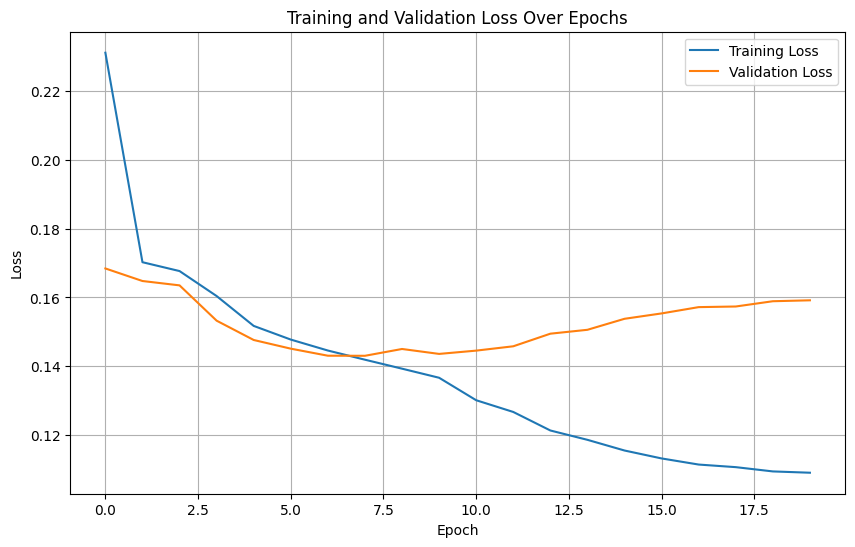

In [32]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_1 + train_losses_2, label='Training Loss')
plt.plot(val_losses_1 + val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Training and Validation Loss only Fine-tuning**

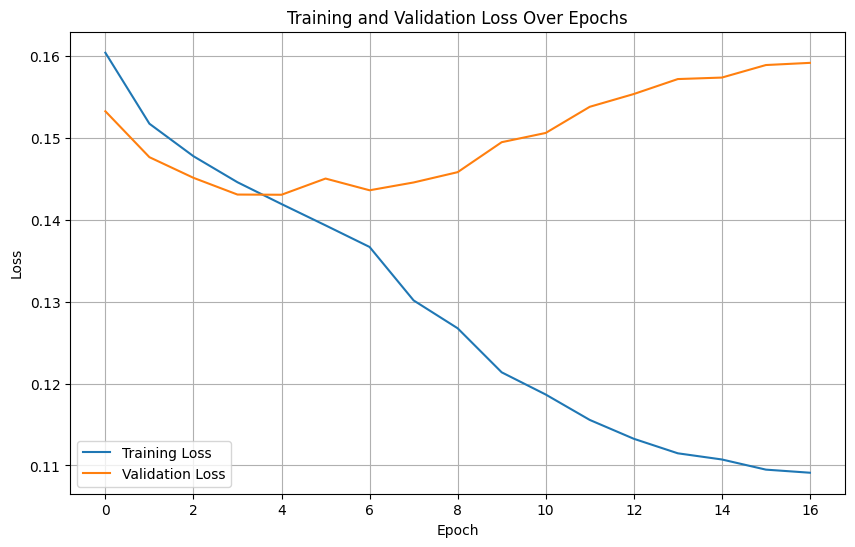

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC**

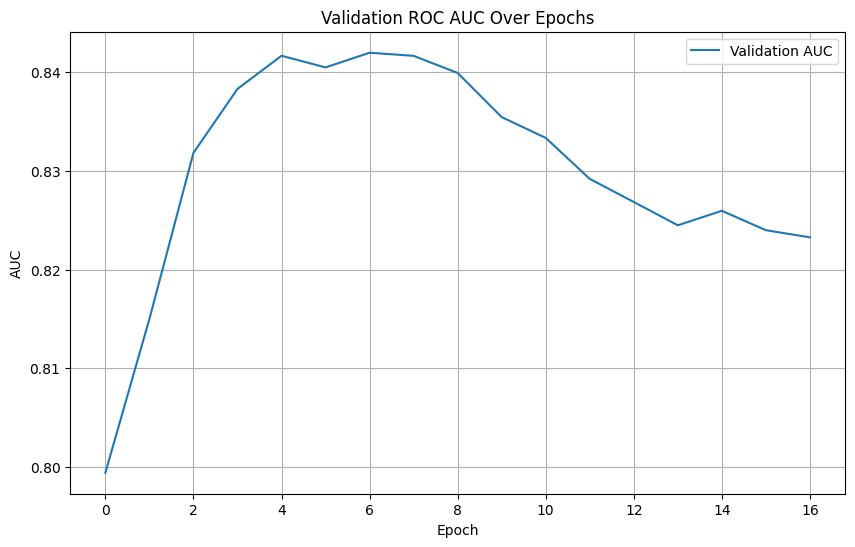

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot Validation AUC only Fine-tuning**

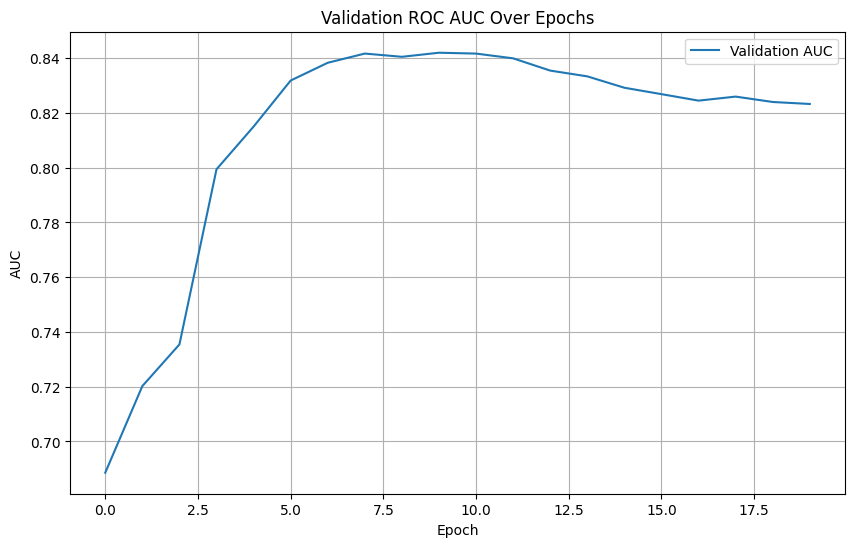

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(val_aucs_1 + val_aucs_2, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation ROC AUC Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

**Plot BYOL Loss**

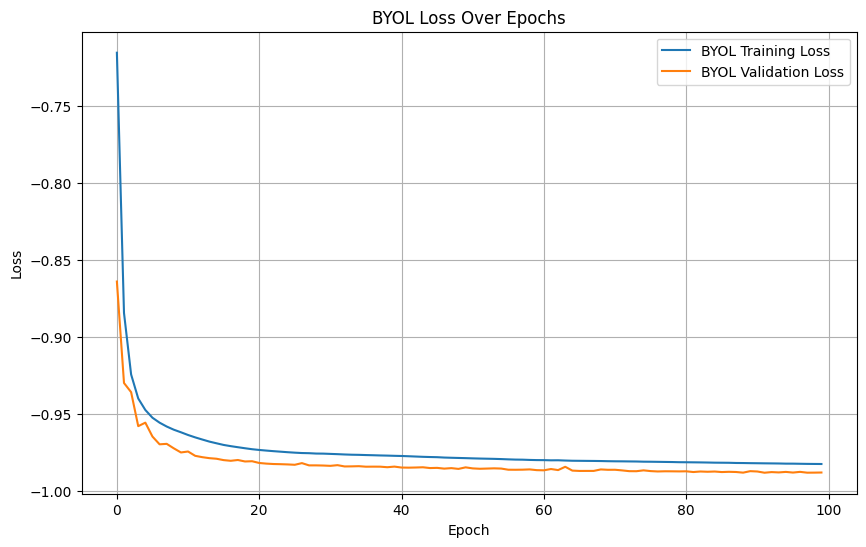

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(byol_train_losses, label='BYOL Training Loss')
plt.plot(byol_val_losses, label='BYOL Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('BYOL Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()